In [35]:
import os
import numpy as np

import torch as th
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# from safetensors.torch import save_model, load_model

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

from typing import List, Union, Callable, Tuple
from torch import Tensor

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.3,
	},
)

# # Constant hyperparameters
DEVICE_AUTODETECT: bool = True
TRAIN_BATCH_SIZE: int = 64	# Batch size for training
TEST_BS: int = 1024	# Batch size for testing
EPOCHS: int = 40	# Number of epochs

CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="mean")
)
EVAL_CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="sum")
)
LR: float = 1e-4	# Learning rate


In [36]:
# Device setup
device: th.device = th.device(
    "mps" if th.backends.mps.is_available() and DEVICE_AUTODETECT else "cpu"
)

In [37]:
# Define the transformations for the training datasets (data augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation and hue
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the transformations for the testing datasets
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/cleaned/Training'
test_dir = 'datasets/cleaned/Testing'

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Create the DataLoaders
train_loader: DataLoader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False)

# Use only a small subset of the data for training to test the model
#test_train_dataset = th.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), 500))
#train_loader = DataLoader(test_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# Example of iterating through the DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


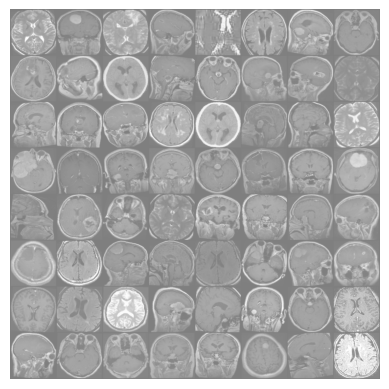

2 1 2 0 2 2 1 3 0 0 2 0 3 1 0 2 3 0 0 2 2 3 3 2 1 0 1 3 3 0 3 1 3 0 0 2 0 3 3 0 0 2 1 3 2 1 1 0 2 2 2 1 3 1 3 2 0 3 3 3 3 1 3 2


In [38]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(tv.utils.make_grid(images))

# Print labels
print(' '.join(f'{labels[j]}' for j in range(len(labels))))

In [39]:
# Data augmentation

class CNN_Alex_mod(th.nn.Module):
    def __init__(self, cls_out: int = 4) -> None:
        super().__init__()
        
        self.conv = th.nn.Sequential(
            th.nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=9, stride=4, padding=0
            ),
            th.nn.BatchNorm2d(96),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=0
            ),
            th.nn.BatchNorm2d(256),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1
            ),
            th.nn.BatchNorm2d(384),
            th.nn.Mish(),
            #th.nn.Conv2d(
            #    in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1
            #),
            #th.nn.BatchNorm2d(384),
            #th.nn.Mish(),
            th.nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1
            ),
            th.nn.BatchNorm2d(256),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Flatten(),
        )

        self.head = th.nn.Sequential(
            th.nn.Linear(1024, 512),
            th.nn.Mish(),
            th.nn.Dropout(p=0.4),
            #th.nn.Linear(512, 512),
            #th.nn.Mish(),
            #th.nn.Dropout(p=0.3),
            th.nn.Linear(512, 128),
            th.nn.Mish(),
            th.nn.Dropout(p=0.4),
            th.nn.Linear(128, cls_out),
            th.nn.Softmax(dim=1),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.head(self.conv(x))

In [40]:
model: CNN_Alex_mod = CNN_Alex_mod().to(device)
model.train()

CNN_Alex_mod(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(9, 9), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Mish()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Mish()
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Mish()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Fl

In [41]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=LR, weight_decay=1e-5 # L2 regularization
)

# Let's define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [42]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()
        
    # Step the scheduler
    scheduler.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)


Training epoch: 100%|██████████| 40/40 [22:23<00:00, 33.60s/it]


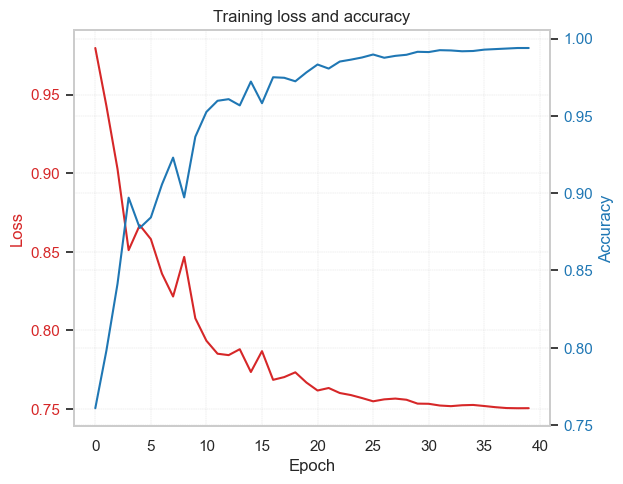

In [43]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [44]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

Final training loss: 0.7504701983361017
Final training accuracy: 0.9938725490196079


In [45]:
# Evaluate the model on the test set
model.eval()  # Remember to set the model in evaluation mode before evaluating it

num_elem: int = 0
trackingcorrect: int = 0

# Since we are just evaluating the model, we don't need to compute gradients
with th.no_grad():
    # Loop over test data
    for _, batched_datapoint_e in enumerate(test_loader):
        x_e, y_e = batched_datapoint_e
        x_e, y_e = x_e.to(device), y_e.to(device)
        modeltarget_e = model(x_e)
        ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
        trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
        num_elem += x_e.shape[0]
    test_acc.append(trackingcorrect / num_elem)
    
print(f"Final test accuracy: {test_acc[-1]}")

Final test accuracy: 0.9809305873379099
